In [26]:
# For development purposes, reload imported modules when source changes
%load_ext autoreload
%autoreload 2

import spikeinterface as si
import spikewidgets as sw
import spikeforest as sf
import spiketoolkit as st
from matplotlib import pyplot as plt
import numpy as np
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
#vcDir_dataset = '/media/jamesjun/LaCie/groundtruth/magland_synth'
vcDir_dataset = '/media/jamesjun/RAID0SSD/spikeforest'
csDatasets_c4 = ('/datasets_noise10_K10', '/datasets_noise10_K20', \
                 '/datasets_noise20_K10', '/datasets_noise20_K20')
csDatasets_c8 = ('/datasets_noise10_K10_C8', '/datasets_noise10_K20_C8', \
                '/datasets_noise20_K10_C8', '/datasets_noise20_K20_C8')


In [39]:
def run_irc(R):
    return st.sorters.ironclust(recording=R,detect_sign=-1,prm_template_name='tetrode_template.prm',tmpdir='.', ironclust_src='~/src/ironclust')


def run_ms4(R):
    return st.sorters.mountainsort4(recording=R,detect_sign=-1,adjacency_radius=-1,detect_threshold=3)


def run_ksort(R):
    return st.sorters.kilosort(recording=R, tmpdir='.', ironclust_src='~/src/ironclust', kilosort_src='~/src/KiloSort')


def run_sc(R):
    return st.sorters.spyking_circus(recording=R, tmpdir='.', detect_sign=-1, adjacency_radius = 100)


def compute_gt(recording, R):
    sorting_true = si.MdaSortingExtractor(firings_file=recording+'/firings_true.mda')
    #R = si.MdaRecordingExtractor(dataset_directory=recording)  
    filt=sw.lazyfilters.bandpass_filter(R,freq_min=300,freq_max=6000)
    snrs=sw.devel.compute_unit_snrs(recording=filt,sorting=sorting_true,unit_ids=sorting_true.getUnitIds())
    sorting_true.setUnitsProperty(property_name='SNR',values=snrs)
    return sorting_true


def compute_result(recording, sorting):
    comparison=sw.SortingComparison(gt, sorting)
    #sw.SortingComparisonTable(comparison).display()
    return comparison


def get_snr_accuracy(a):
    b = a.getSorting1()
    units = b.getUnitIds()
    snrs = b.getUnitsProperty(property_name='SNR',unit_ids=units)
    agreements = [a.getAgreementFraction(unit) for unit in units]
    return snrs, agreements


def flatten_list(list1):
    list2 = [item for sublist in list1 for item in sublist]
    return list2


def collect_snr_accuracy(results):
    snrs = list()
    accuracies = list()
    for iRecording in range(len(results)):
        snrs1, accuracy1 = get_snr_accuracy(results[iRecording])
        snrs.append(snrs1)
        accuracies.append(accuracy1)
    snrs = flatten_list(snrs)
    accuracies = flatten_list(accuracies)
    return snrs, accuracies


def plot_snr_accuracy(snrs, accuracies, vcTitle='', ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    vcTitle = vcTitle + ": %0.2f/%0.2f(%d)"%(np.mean(accuracies), np.std(accuracies),len(accuracies))        
    ax.plot(snrs, accuracies, '.')
    ax.set(xlabel='SNR', ylabel='Accuracy', title=vcTitle)
    ax.grid()
    ax.set_ylim([0,1])
    
    
def plot_snr_accuracy_all(list_results, csDatasets, vcTitle=''):
    nDataset = len(list_results)
    fig, vhAxes = plt.subplots(1, nDataset, figsize=(20,4))
    vhAxes=vhAxes.flatten()
    for iD in range(nDataset):        
        snrs, accuracies = collect_snr_accuracy(list_results[iD])
        vcTitle1 = vcTitle + csDatasets[iD]
        plot_snr_accuracy(snrs, accuracies, vcTitle1, ax=vhAxes[iD])
    
    
def run_sort_all(dataset1, nFiles=10):
    results_irc = list(range(nFiles))
    results_ms4 = list(range(nFiles))
    results_ksort = list(range(nFiles))
    #results_sc = list(range(nFiles))
    for iRecording in range(nFiles):
        recording1 = dataset1 + "/%03d_synth"%(iRecording+1)
        print(recording1)
        R1 = si.MdaRecordingExtractor(dataset_directory=recording1)    
        sorting_true1 = compute_gt(recording1, R1);
        results_irc[iRecording] = sw.SortingComparison(sorting_true1,run_irc(R1))
        results_ms4[iRecording] = sw.SortingComparison(sorting_true1,run_ms4(R1))
        results_ksort[iRecording] = sw.SortingComparison(sorting_true1,run_ksort(R1))
    return results_irc, results_ms4, results_ksort


def run_datasets(vcDir_dataset, csDatasets, nFiles=10):
    nDataset = len(csDatasets)
    results_irc = list(range(nDataset))
    results_ms4 = list(range(nDataset))
    results_ksort = list(range(nDataset))
    for iD in range(nDataset):
        dataset1 = vcDir_dataset + csDatasets[iD]
        results_irc[iD], results_ms4[iD], results_ksort[iD] = run_sort_all(dataset1, nFiles)
    return results_irc, results_ms4, results_ksort


def load_results(vcFile_npy):
    results = np.load(vcFile_npy)
    results = results.item()
    results_irc = results.get('irc')
    results_ms4 = results.get('ms4')
    results_ksort = results.get('ksort')
    return results_irc, results_ms4, results_ksort


In [5]:
[results_irc_c4, results_ms4_c4, results_ksort_c4] = run_datasets(vcDir_dataset, csDatasets_c4)
results_c4 = {"irc":results_irc_c4, "ms4":results_ms4_c4, "ksort":results_ksort_c4}
np.save('results_c4_all.npy', results_c4)

/media/jamesjun/RAID0SSD/spikeforest/datasets_noise10_K10_C8/001_synth
Reading timeseries header...
Num. channels = 8, Num. timepoints = 18000000, duration = 10.0 minutes
Creating .params file...
Running IronClust...
matlab -nosplash -nodisplay -r "addpath('~/src/ironclust', '~/src/ironclust/matlab', '~/src/ironclust/mdaio'); p_ironclust('.', './ironclust_dataset/raw.mda', './ironclust_dataset/geom.csv', '', '', './firings.mda', './ironclust_dataset/argfile.txt'); quit;"


                            < M A T L A B (R) >

                  Copyright 1984-2018 The MathWorks, Inc.

                   R2018a (9.4.0.813654) 64-bit (glnxa64)

                             February 23, 2018





	Non-Degree Granting Education License -- for use at non-degree granting, nonprofit,

	educational organizations only.  Not for government, commercial, or other organizational use.



 

To get started, type one of these: helpwin, helpdesk, or demo.

For product information, visit www.mathworks.com.

 

In [ ]:
[results_irc_c8, results_ms4_c8, results_ksort_c8] = run_datasets(vcDir_dataset, csDatasets_c8, nFiles=5)
results_c8 = {"irc":results_irc_c8, "ms4":results_ms4_c8, "ksort":results_ksort_c8}
np.save('results_c8_all.npy', results_c8)

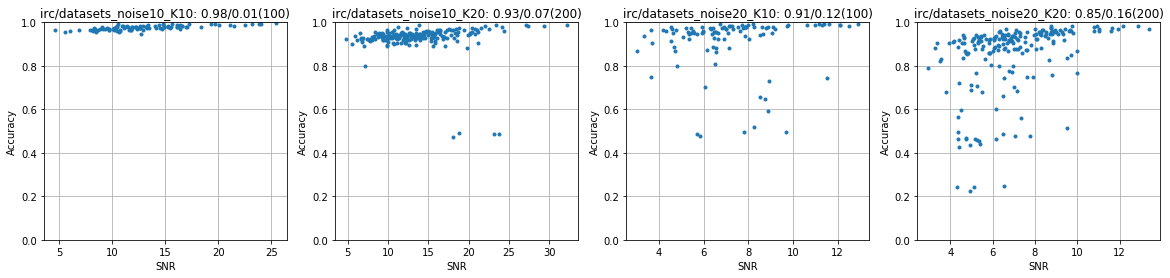

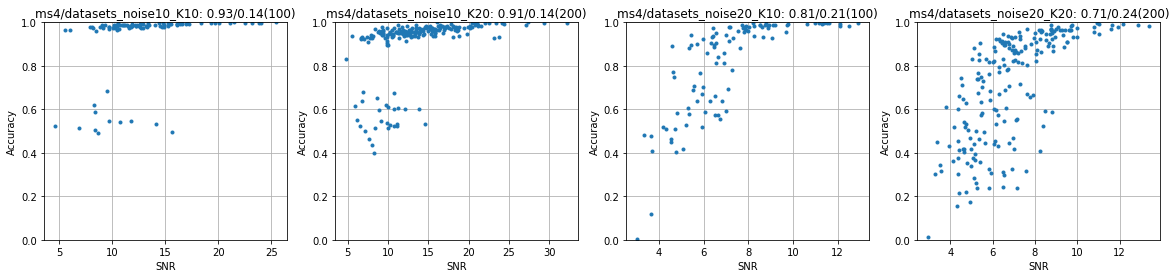

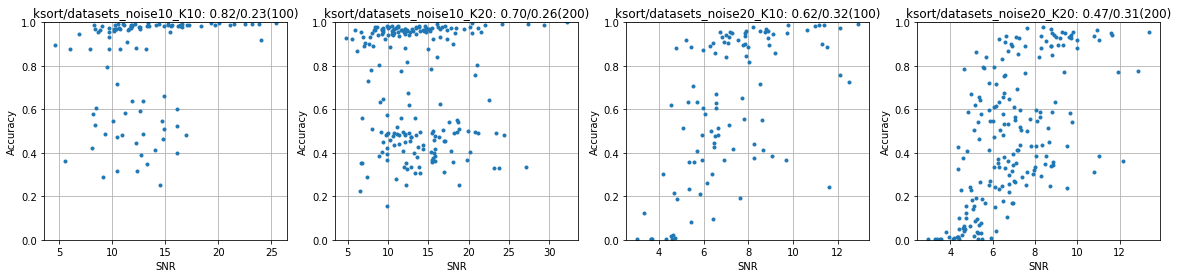

In [40]:
results_irc_c4, results_ms4_c4, results_ksort_c4 = load_results('results_c4_all.npy')
plot_snr_accuracy_all(results_irc_c4, csDatasets_c4, vcTitle='irc')
plot_snr_accuracy_all(results_ms4_c4, csDatasets_c4, vcTitle='ms4')
plot_snr_accuracy_all(results_ksort_c4, csDatasets_c4, vcTitle='ksort')

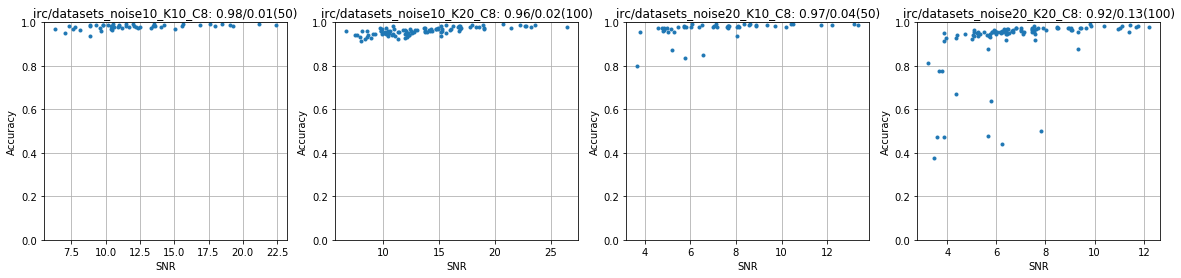

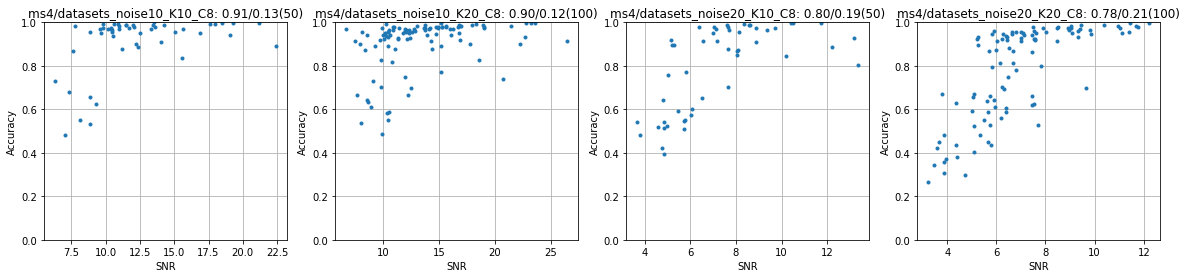

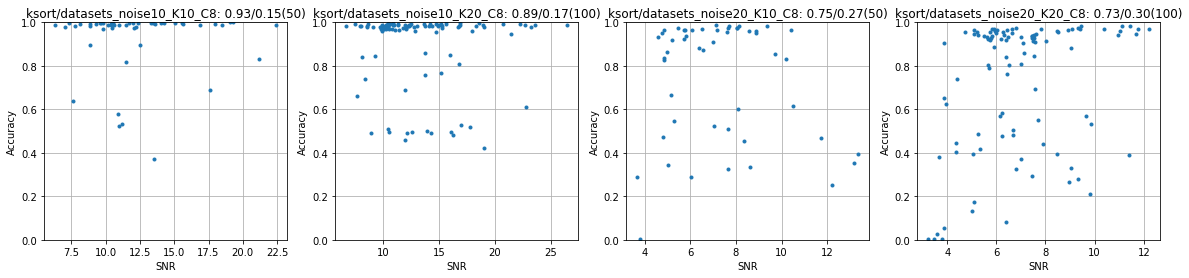

In [41]:
results_irc_c8, results_ms4_c8, results_ksort_c8 = load_results('results_c8_all.npy')
plot_snr_accuracy_all(results_irc_c8, csDatasets_c8, vcTitle='irc')
plot_snr_accuracy_all(results_ms4_c8, csDatasets_c8, vcTitle='ms4')
plot_snr_accuracy_all(results_ksort_c8, csDatasets_c8, vcTitle='ksort')